# Qué características de un país influyen en su producción de energías bajas en carbono?

In [27]:
# Se importan las librerías que se utilizarán: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import plotly.express as px
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# Tengo que reorganizar poniendo modelos de regresion, rf y svr primero. Asi decidimos usar RF, y despues la funcion de optimizacion de RF. Evaluacion y validacion de ese modelo, y tuki. 

# Carga y preprocesamiento de datos

Cargamos los datos y observamos el dataframe

In [94]:
wec = pd.read_csv(r'../datasets/wec_reg_lineal')  
wec.head(10)

,country,continente,year,population,renewables_electricity,nuclear_electricity,low_carbon_electricity,cluster,nivel_ingresos
0,Afghanistan,Asia,2011,30.117,0.595,0.0,0.595,4.0,bajo
1,Afghanistan,Asia,2012,31.161,0.738,0.0,0.738,4.0,bajo
2,Afghanistan,Asia,2013,32.270,0.885,0.0,0.885,4.0,bajo
3,Afghanistan,Asia,2014,33.371,1.000,0.0,1.000,4.0,bajo
4,Afghanistan,Asia,2015,34.414,1.034,0.0,1.034,4.0,bajo
5,Afghanistan,Asia,2016,35.383,1.060,0.0,1.060,4.0,bajo
6,Afghanistan,Asia,2017,36.296,1.088,0.0,1.088,4.0,bajo
7,Afghanistan,Asia,2018,37.172,0.965,0.0,0.965,4.0,bajo
8,Afghanistan,Asia,2019,38.042,0.880,0.0,0.880,4.0,bajo
9,Albania,Europa,2011,2.929,4.091,0.0,4.091,0.0,medio-alto


In [30]:
# Se consultan los datos únicos que integran la columna country 
n_paises = len(wec['country'].unique())
print(f"Contamos con datos de {n_paises} países.")

Contamos con datos de 203 países.


Creamos la columna con la que trabajaremos: **energía baja en carbono producida per cápita (teravatios-hora/habitante)**

In [31]:

wec["lc_per_capita"] = wec["low_carbon_electricity"]/wec["population"]

In [32]:
fig = px.scatter(x=wec["population"], y=wec["lc_per_capita"], color=wec["country"])
# Especificamos el diseño del gráfico
fig.update_layout(
    xaxis_title='Población (millones de habitantes)',
    yaxis_title='Producción per capita (teravatios-hora/habitante)',
    title='Producción de electricidad low-carbon per capita en funcion de la población',
)
fig.show()

In [33]:
wec.sort_values("population", ascending= False)

,country,continente,year,population,renewables_electricity,nuclear_electricity,low_carbon_electricity,cluster,nivel_ingresos,lc_per_capita
350,China,Asia,2019,1433.784064,2043.258,348.7,2391.958,-1.0,medio-alto,1.668283
349,China,Asia,2018,1427.648000,1870.500,294.4,2164.900,-1.0,medio-alto,1.516410
348,China,Asia,2017,1421.021952,1694.200,248.1,1942.300,-1.0,medio-alto,1.366833
347,China,Asia,2016,1414.049024,1547.700,213.2,1760.900,-1.0,medio-alto,1.245289
346,China,Asia,2015,1406.848000,1391.800,171.4,1563.200,-1.0,medio-alto,1.111136
...,...,...,...,...,...,...,...,...,...,...
1201,Niue,Oceanía,2015,0.002000,0.000,0.0,0.000,1.0,alto,0.000000
1204,Niue,Oceanía,2018,0.002000,0.000,0.0,0.000,1.0,alto,0.000000
1203,Niue,Oceanía,2017,0.002000,0.000,0.0,0.000,1.0,alto,0.000000
1200,Niue,Oceanía,2014,0.002000,0.000,0.0,0.000,1.0,alto,0.000000


Descartamos los países India y China porque hemos corroborado en un análisis previo que son outliers respecto de la población. 

In [34]:
wec = wec[wec["country"] != "China"]
wec = wec[wec["country"] != "India"]

Convertimos la variable cluster a objeto para que no la tome como número, ya que no tiene sentido numérico. 

In [35]:
wec['cluster'] = wec['cluster'].astype('object')

## Definicion de variables predictoras y variable respuesta. 

In [36]:
predictoras = ['population', 'continente', 
              'nivel_ingresos', 'year', 'cluster']
respuesta = 'lc_per_capita'


Realizamos encoding de las columnas predictoras categoricas dado que el modelo no acepta variables de tipo stirng. 

In [37]:
wec_encoded = pd.get_dummies(wec[predictoras], drop_first=True)

Seleccionamos nuestras variables predictoras o explicativas (var_predict) y nuestra variable respuesta que queremos proyectar (var_respuesta).

In [38]:
X = wec_encoded
y = wec[respuesta]

In [39]:
X.shape, y.shape

((1809, 15), (1809,))

In [40]:
# Calculate the interquartile range (IQR)
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Keep only data points within the bounds
filtered_data = ((y >= lower_bound) & (y <= upper_bound))

# Use the filtered data for linear regression
x_filtered = X[filtered_data]
y_filtered = y[filtered_data]

In [41]:
fig = px.scatter(x=x_filtered["population"], y=y_filtered)
fig.show()

In [42]:
x_filtered.shape, y_filtered.shape

((1640, 15), (1640,))

In [43]:
x, y = np.array(x_filtered), np.array(y_filtered)

Separamos dataset en datos de training y de testing. <br>
Se entrenará con 80% de los datos y se testeará con el 20% de los datos.

In [44]:
# Importamos la librearia para separar el dataset.
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

In [46]:
X_train

array([[2.877, 2011, False, ..., False, False, False],
       [8.94, 2012, True, ..., False, True, False],
       [2.495, 2019, False, ..., False, False, False],
       ...,
       [0.519, 2011, True, ..., False, True, False],
       [68.145, 2013, False, ..., False, False, False],
       [4.981, 2019, False, ..., False, False, False]], dtype=object)

In [47]:
X_train.shape

(1312, 15)

In [48]:
y_test.shape

(328,)

## Funciones de evaluación y optimización de modelos

In [49]:
# Se calculan los errores 
def evaluation(y_test, predictions):
    """
    Funcion que devuelve el error absoluto medio y el error porcentual absoluto medio.

    :param y_test: valores reales
    :param predictions: valores predichos

    :return: Devuelve el error absoluto medio y el error porcentual absoluto medio.
    """
    # Calcula mae
    mae = mean_absolute_error(y_test, predictions)
    #calculate mape
    mape = np.mean((np.abs(y_test - predictions)/y_test)*100)
    #print calculated values
    print(f"El error absoluto medio para el modelo es {round(mae, 2)}")
    print(f"El error porcentual absoluto medio para el modelo es {round(mape, 2)}")

In [50]:
def graph_real_pred(y_test, predictions, color):
    """
    Funcion que grafica los valores reales vs. predichos
    :param y_test: valores reales
    :param predictions: valores predichos
    :param color: color para el plot.

    :return: Scatterplot mostrando la relacion entre el valor real y el predicho
    """
    plt.scatter(y_test, predictions, c=color, s=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Valor real', size=15, labelpad=1)
    plt.ylabel('Valor predicho', size=15, labelpad=1)
   

In [51]:
# Se consultan los hiperparámetros más importantes
def feature_importance(model, feature_list):
    """
    Function that gets and plots the feature importance
    for the given model
    :param model: the model to evaluaate
    :param feature_list: a list of features contained in the model

    :returns a plot with feature importance
    """
    # Obtiene la lista de importancias
    importances = list(model.feature_importances_)
    # Junta los nombres de los atributos y las importancias
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Ordena por orden de importancia
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print la lista de importancias
    [print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances];
    # Colores
    colors = cm.rainbow(np.linspace(0, 1, len(feature_list)))

    # Caracteristicas en orden de importancia
    characteristics = [x[0] for x in feature_importances]
    # Obtiene las importancias
    importances_plot = [x[1] for x in feature_importances]
    # Grafica un bar plot
    plt.figure(figsize=(25,6))
    plt.bar(characteristics, importances_plot, color=colors)
    # Personalizamos el grafico
    plt.xticks(list(range(len(characteristics))), characteristics, rotation = 90)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().subplots_adjust(bottom=0.3);

## Búsqueda del mejor estimador

In [52]:
# Valores para los parametros a optimizar
param_grid_rf = {
    'criterion': ['absolute_error'],
    'n_estimators': [70, 80, 90, 100, 120],
    'max_features': ['log2','sqrt'],
    'max_depth': [1, 3, 5, 10, 20, 50],
    'min_samples_leaf': [1, 3, 5, 10, 20, 50]
}

In [53]:
# Inicializamos un modelo
grid_regresor = RandomForestRegressor(random_state=42)

In [54]:
# Creamos la busqueda
rf_search = GridSearchCV(estimator=grid_regresor, param_grid=param_grid_rf,
                         cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

In [55]:
# Corremos el gridsearch con una validación usando 3 folds.
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'],
                         'max_depth': [1, 3, 5, 10, 20, 50],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10, 20, 50],
                         'n_estimators': [70, 80, 90, 100, 120]},
             scoring='neg_mean_absolute_error', verbose=2)

In [56]:
rf_search.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_depth=20,
                      max_features='log2', n_estimators=120, random_state=42)

In [57]:
rf_search.best_params_

{'criterion': 'absolute_error',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 120}

In [58]:
rf_search.best_score_

-0.14986975275401151

In [59]:
# Asignamos el mejor estimador a mejor_regresor
mejor_regresor = RandomForestRegressor(criterion='absolute_error', n_estimators=120, max_depth=20, max_features='log2', min_samples_leaf=1)

In [60]:
# Entrenamos el modelo
mejor_regresor.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=20,
                      max_features='log2', n_estimators=120)

In [61]:
# Hacemos la prediccion para el test de evaluación
predicciones = mejor_regresor.predict(X_test)

## Error absoluto medio

In [62]:
# Error
evaluation(y_test, predicciones)

El error absoluto medio para el modelo es 0.15
El error porcentual absoluto medio para el modelo es inf


C:\Users\Luna\AppData\Local\Temp\ipykernel_14908\476445176.py:14: RuntimeWarning:

divide by zero encountered in divide



## R scored

In [63]:
r2_score(y_test, predicciones)

0.8852354562573883

## Reales vs predichos

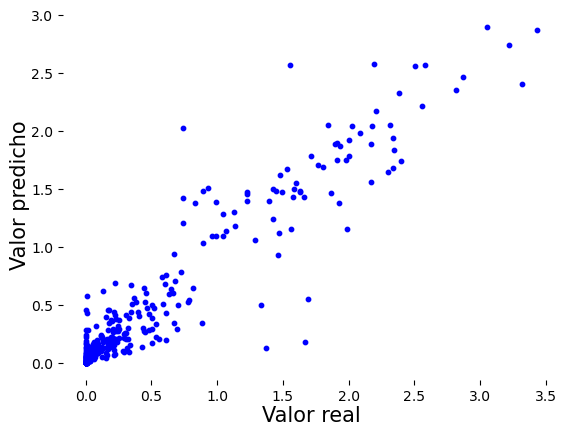

In [64]:
# Correlacion
graph_real_pred(y_test, predicciones, color="b")

## Feature importance

Variable: population Importance: 0.3
Variable: nivel_ingresos Importance: 0.12
Variable: continente Importance: 0.08
Variable: year Importance: 0.02
Variable: cluster Importance: 0.01


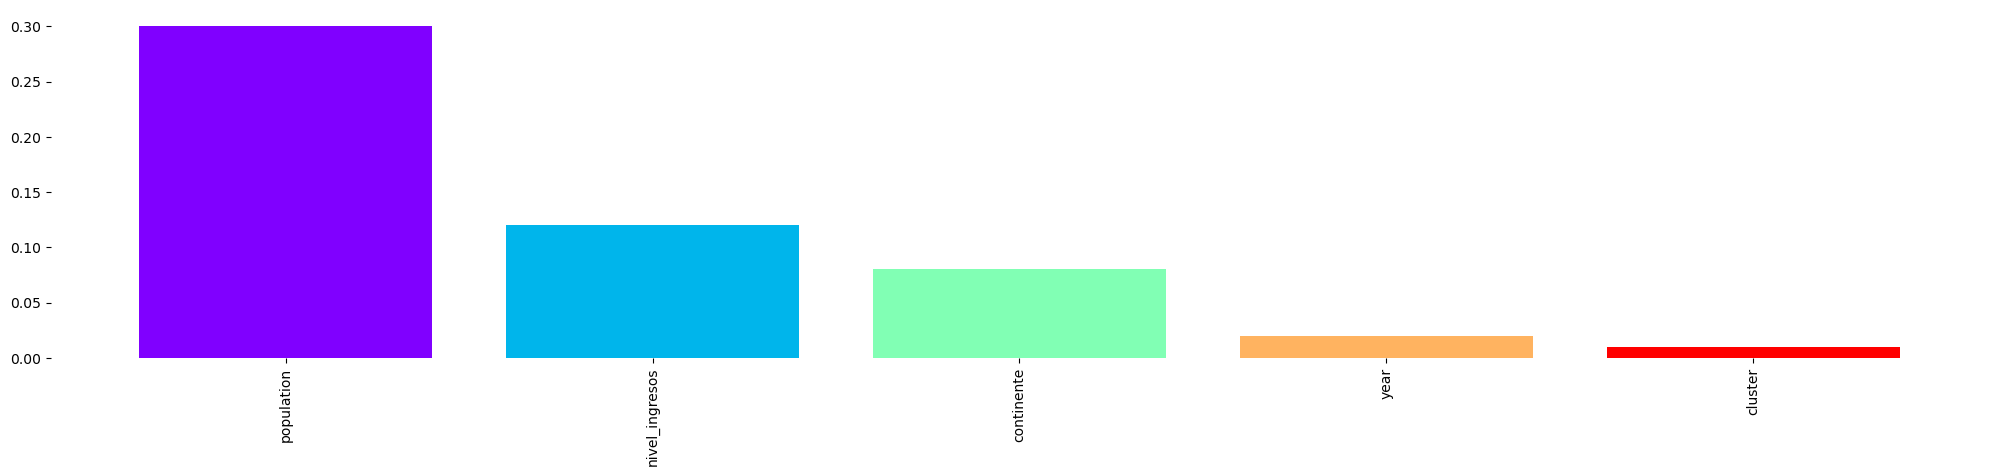

In [65]:
# Importancia de cada feature
feature_importance(mejor_regresor, predictoras)

In [66]:
df_lm_factor = LinearRegression()
df_lm_factor.fit(wec_encoded, wec[respuesta])
print(f'Intercept: {df_lm_factor.intercept_:.3f}') 
print('Coefficients:')
for name, coef in zip(X.columns, df_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -42.196
Coefficients:
 population: -0.002319285370995624
 year: 0.02240723968637512
 continente_Europa: 2.783410002117187
 continente_Norteamérica: 0.10600363958865591
 continente_Oceanía: 0.24659053590278207
 continente_Sudamérica: 0.4305370570425706
 continente_África: -0.5252695613402579
 nivel_ingresos_bajo: -1.9071153438084172
 nivel_ingresos_bajo-medio: -1.5329386272408443
 nivel_ingresos_medio-alto: -1.6543764443965052
 cluster_0.0: 4.066954811387985
 cluster_1.0: -2.0048603659157767
 cluster_2.0: -1.3089053503347092
 cluster_3.0: -1.6179406654432833
 cluster_4.0: 0.6961165253637964


c:\Users\Luna\anaconda3\envs\ds-python\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\Luna\anaconda3\envs\ds-python\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\Luna\anaconda3\envs\ds-python\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\Luna\anaconda3\envs\ds-python\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\Luna\anaconda3\envs\ds-python\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is

### Modelo 1

In [68]:
from sklearn.linear_model import LinearRegression
regressor1 = LinearRegression()
regressor1.fit(X_train, y_train)

LinearRegression()

In [69]:
y_pred1 = regressor1.predict(X_test)

In [70]:
print(regressor1.intercept_)

-20.570768673584443


In [71]:
print(regressor1.coef_)

[-1.12431924e-03  1.10241445e-02  5.28685342e-01 -2.52861999e-01
 -4.79090485e-02  2.75328912e-01 -4.11988014e-01 -4.00530382e-01
 -2.77851045e-01 -4.21935003e-02 -2.54276567e-01 -1.24693939e+00
 -4.88592932e-01 -8.37789041e-01 -4.03109564e-01]


Evaluamos metricas del modelo

In [72]:
r2_score(y_test, y_pred1)

0.5824332613424814

In [73]:
mean_absolute_error(y_test, y_pred1)

0.37845583504128766

### Modelo 2: Random Forest

In [74]:
# Se inicia el modelo
regresor_rf2 = RandomForestRegressor(criterion='absolute_error', random_state=42, n_estimators = 1000)

In [75]:
# Se entrena el modelo
regresor_rf2.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', n_estimators=1000,
                      random_state=42)

In [76]:
regresor_rf2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [77]:
# Se predicen los valores para el set de testeo
y_pred_rf2 = regresor_rf2.predict(X_test)

In [78]:
y_test_mod = np.where(y_test == 0, y_test + 1.000000e-01, y_test)


In [79]:
y_test[6], y_test_mod[6]

(0.1654842035049421, 0.1654842035049421)

In [80]:
r2_score(y_test, y_pred_rf2)

0.9327827888806889

In [81]:
# Se calcula el error medio absoluto
mean_absolute_error(y_test, y_pred_rf2)

0.09185732880019562

In [82]:
errors_rf2 = abs(y_pred_rf2 - y_test)

In [83]:
errors_rf2[6]

0.08468671778510692

In [84]:
errors_rf2[1], y_test_mod[1], errors_rf2[1]/y_test_mod[1]

(0.048218370942224115, 0.28538892782060266, 0.1689566981818387)

In [85]:
y_pred_rf2[6]

0.25017092129004903

In [86]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_ = mean_absolute_percentage_error(y_test, y_pred_rf2)


C:\Users\Luna\AppData\Local\Temp\ipykernel_14908\2155201222.py:3: RuntimeWarning:

divide by zero encountered in divide



In [87]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors_rf2 / y_test)# Calculate and display accuracy
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


C:\Users\Luna\AppData\Local\Temp\ipykernel_14908\2270586833.py:2: RuntimeWarning:

divide by zero encountered in divide



In [88]:
mape[6]

51.17510674218387

In [89]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred_rf2)
mse


0.03885351500908534

In [90]:
def concordance_correlation_coefficient(y_true, y_pred):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)

    ccc = (2 * corr * np.sqrt(var_true) * np.sqrt(var_pred)) / (var_true + var_pred + (mean_true - mean_pred)**2)
    return ccc

ccc = concordance_correlation_coefficient(y_test, y_pred_rf2)


In [91]:
ccc

0.9655447708242133

In [92]:
concordance_correlation_coefficient(y_test, y_pred1)

0.7533192119465959

In [93]:
concordance_correlation_coefficient(y_test_mod, y_pred_svr)

NameError: name 'y_pred_svr' is not defined

### Modelo 3: Support Vector Machine

In [ ]:
# Se inicia el modelo
regresor_svr = SVR(C=1.0, epsilon=0.2)

In [ ]:
# Se entrena el modelo
regresor_svr.fit(X_train, y_train)

SVR(epsilon=0.2)

In [ ]:
regresor_svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.2,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
#Se predicen los valores para el set de testeo
y_pred_svr = regresor_svr.predict(X_test)

In [ ]:
# Se calcula el error medio absoluto
mean_absolute_error(y_test, y_pred_svr)

0.5056580859190092

In [ ]:
np.mean((np.abs(y_pred_svr - y_test)/y_test)*100)

C:\Users\Luna\AppData\Local\Temp\ipykernel_22552\145190498.py:1: RuntimeWarning:

divide by zero encountered in divide



inf

In [ ]:
evaluation(y_test, y_pred1)

El error absoluto medio para el modelo es 0.38
El error porcentual absoluto medio para el modelo es inf


C:\Users\Luna\AppData\Local\Temp\ipykernel_22552\476445176.py:14: RuntimeWarning:

divide by zero encountered in divide



In [ ]:
evaluation(y_test, predicciones)

El error absoluto medio para el modelo es 0.15
El error porcentual absoluto medio para el modelo es inf


C:\Users\Luna\AppData\Local\Temp\ipykernel_22552\476445176.py:14: RuntimeWarning:

divide by zero encountered in divide



In [ ]:
evaluation(y_test, y_pred_svr)

El error absoluto medio para el modelo es 0.51
El error porcentual absoluto medio para el modelo es inf


C:\Users\Luna\AppData\Local\Temp\ipykernel_22552\476445176.py:14: RuntimeWarning:

divide by zero encountered in divide



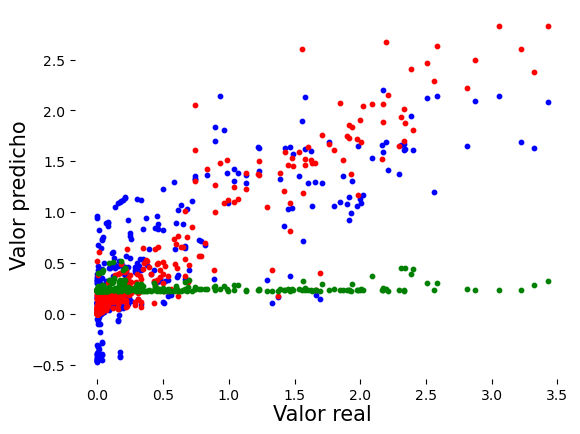

In [ ]:
graph_real_pred(y_test, y_pred1, color="b")
graph_real_pred(y_test, predicciones, color="r")
graph_real_pred(y_test, y_pred_svr, color="g")
plt.show()

In [ ]:
feature_importance(predicciones, predictoras)

AttributeError: 'numpy.ndarray' object has no attribute 'feature_importances_'

In [ ]:
fitted = regresor_rf2.predict(wec_encoded[X.columns])
residuals = wec[respuesta] - fitted

c:\Users\Luna\anaconda3\envs\ds-python\Lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names

c:\Users\Luna\anaconda3\envs\ds-python\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\Luna\anaconda3\envs\ds-python\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

c:\Users\Luna\anaconda3\envs\ds-python\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

